In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
%matplotlib inline

# Scrape Documents

In [2]:
from bs4 import BeautifulSoup
import requests
import datetime as dt

In [3]:
def gather_links(pages, startPage):
    pageList = [] #list of album review pages
    linkList = [] #list of album links
    for x in range(startPage,(startPage+pages)): #check the first n pages after the requested one
        pageList.append(requests.get("https://pitchfork.com/reviews/albums/?page=" + str(x))) #add each page to list
    for page in pageList:
        soup = BeautifulSoup(page.content, 'html.parser') #parse its contents
        links = soup.find_all(class_="review__link") #gather its links (in raw html)
        for link in links: #for each link
            linkList.append(link.get('href')) #append only the link itself
    return linkList

def gather_info(album_link):
    page = requests.get("https://pitchfork.com" + album_link) #request URL
    soup = BeautifulSoup(page.content, 'html.parser') #parse with beautifulsoup
    title = str(soup.find('title').string) #album and artist 
    try:
        score = float((soup.find(class_="score").string)) #score
    except AttributeError:
        score = None
    try:
        genre = soup.find(class_="genre-list__link").string #genre
    except AttributeError:
        genre = None
    sents = [element.text for element in soup.find_all('p')] #cleaned text output
    string = " ".join(sents)
    try:
        date = str(soup.find(class_="pub-date").string) #date
    except AttributeError:
        date = None
    #create dataframe with column labels
    d = {'artist': [get_artist(title)], 'album': [get_album(title)], 'score': [score], 'genre': [genre], 'review': [string], 'best': [1 if "Best new" in string else 0], 'date': [date]}
    df = pd.DataFrame(data=d)
    return df

def get_artist(title):
    str = ''
    for character in title: #for each character in title
        #add to string up until ':' 
        if character is not ':':
            str += character
        else:
            break
    return str

def get_album(title):
    str = ''
    #find ':' and index and start there
    index = title.find(":")
    title = title[index+2:]
    #for each character afterwards, add it until '|'
    for character in title:
        if character is '|':
            break
        else:
            str +=character
    return str[:-14] #return just the title

def gather(pages, startPage, fileLocation, fileName):
    linkList = gather_links(pages, startPage) #gather links
    first = True #special variable for first scrape
    newDF = pd.DataFrame()
    for link in linkList: #for each link
        data = gather_info(link) #gather info
        #if first, newDF becomes the initial dataframe
        if first:
            newDF = data
            first = False
        #otherwise append it
        else:
            newDF = newDF.append(data, ignore_index = True)
    #when scraping complete, export to .csv 
    newDF.to_csv(path_or_buf = fileLocation + "/" + fileName + ".csv")
    #return true if gather was successful
    return True

In [4]:
# Since data has been scraped once and put into CSV,
# we commented out this section to scrape from the website.
# It takes over 5 hours to run.

# start = dt.datetime.now()
# gather(254, 1, "C:\\Users\\sanderdv\\OneDrive - University of Cincinnati\\School\\Second Year\\Spring 2019\\Machine Learning and Data Analytics\\Project", "pitchfork1")
# print(str(dt.datetime.now()-start))

# start = dt.datetime.now()
# gather(254, 255, "C:\\Users\\sanderdv\\OneDrive - University of Cincinnati\\School\\Second Year\\Spring 2019\\Machine Learning and Data Analytics\\Project", "pitchfork2")
# print(str(dt.datetime.now()-start))

# start = dt.datetime.now()
# gather(254, 509, "C:\\Users\\sanderdv\\OneDrive - University of Cincinnati\\School\\Second Year\\Spring 2019\\Machine Learning and Data Analytics\\Project", "pitchfork3")
# print(str(dt.datetime.now()-start))

# start = dt.datetime.now()
# gather(254, 763, "C:\\Users\\sanderdv\\OneDrive - University of Cincinnati\\School\\Second Year\\Spring 2019\\Machine Learning and Data Analytics\\Project", "pitchfork4")
# print(str(dt.datetime.now()-start))


# Text Preprocessing

In [5]:
# load the pitchfork_df from the CSV
pitchfork_df = pd.read_csv('pitchfork1.csv')
pitchfork_df=pitchfork_df.append(pd.read_csv('pitchfork2.csv'))
pitchfork_df=pitchfork_df.append(pd.read_csv('pitchfork3.csv'))
pitchfork_df=pitchfork_df.append(pd.read_csv('pitchfork4.csv'))
pitchfork_df = pitchfork_df.reset_index()
print(pitchfork_df.shape)

(12168, 9)


In [6]:
# Replace missing values
pitchfork_df.head()
values = {'score':-1}
pitchfork_df = pitchfork_df.fillna(value=values)
#pitchfork_df['score'].values
misc = {'genre':'Misc'}
pitchfork_df = pitchfork_df.fillna(value=misc)

In [7]:
def cleanReview(stringToClean):
    return prepStringForProcessing(stringToClean)

def prepStringForProcessing(inputString):
    # this code cleans a string. It takes
    # a string and removes the puncuation 
    # from the string. The cleaned string 
    # is returned
    
    # remove puncuation
    outputString = inputString.replace(',','')
    outputString = outputString.replace('.','')
    outputString = outputString.replace(':','')
    outputString = outputString.replace(';','')
    outputString = outputString.replace('@','')
    outputString = outputString.replace('"','')
    outputString = outputString.replace("'","")
    outputString = outputString.replace("'","")
    outputString = outputString.replace('?','')
    outputString = outputString.replace('!','')
    outputString = outputString.replace('#','')
    outputString = outputString.replace('%','')
    outputString = outputString.replace('&','')
    outputString = outputString.replace('$','')
    outputString = outputString.replace('^','')
    outputString = outputString.replace('*','')
    outputString = outputString.replace('(','')
    outputString = outputString.replace(')','')
    outputString = outputString.replace('!','')
    outputString = outputString.replace('-','')
    
    # We should remove stopwords here
    return outputString.lower();


In [8]:
for i in range(0,len(pitchfork_df)-1):
    pitchfork_df['review'][i] = cleanReview(pitchfork_df['review'][i])

/Users/johncrider/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Exploratory Analysis

/Users/johncrider/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


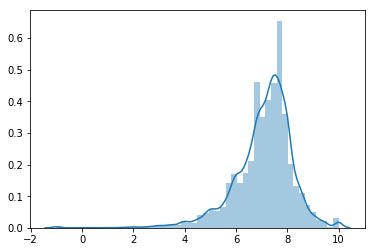

In [9]:
#Get histogram of scores
sns.distplot(pitchfork_df['score'].values)

In [10]:
print(np.std(pitchfork_df['score'].values))
print(np.mean(pitchfork_df['score'].values))

1.1352786888290622
7.090154503616042


In [11]:
pitchfork_df.head()

,index,Unnamed: 0,artist,album,score,genre,review,best,date
0,0,0,Laurel Halo,DJ-Kicks,7.7,Electronic,on her first commercial mix album the producer...,0,11 hrs ago
1,1,1,Prefab Sprout,I Trawl the Megahertz,8.5,Electronic,best new reissue this lost prefab sprout album...,1,11 hrs ago
2,2,2,USA/Mexico,Matamoros,7.3,Rock,usa/mexico are sludgy nasty and unclassifiable...,0,11 hrs ago
3,3,3,Tamaryn,Dreaming in the Dark,6.5,Rock,on her new album tamaryn aims for skyhigh 80sg...,0,11 hrs ago
4,4,4,Nilüfer Yanya,Miss Universe,8.3,Pop/R&B,best new music the rapturous debut from the br...,1,March 22 2019


In [12]:
# I picked 7.0 as an arbitrary cutoff between good and bad.

pitchfork_df['rating'] = np.where(pitchfork_df['score']>7.0,1,0)

In [13]:
#show new column 'rating'
pitchfork_df.head()

,index,Unnamed: 0,artist,album,score,genre,review,best,date,rating
0,0,0,Laurel Halo,DJ-Kicks,7.7,Electronic,on her first commercial mix album the producer...,0,11 hrs ago,1
1,1,1,Prefab Sprout,I Trawl the Megahertz,8.5,Electronic,best new reissue this lost prefab sprout album...,1,11 hrs ago,1
2,2,2,USA/Mexico,Matamoros,7.3,Rock,usa/mexico are sludgy nasty and unclassifiable...,0,11 hrs ago,1
3,3,3,Tamaryn,Dreaming in the Dark,6.5,Rock,on her new album tamaryn aims for skyhigh 80sg...,0,11 hrs ago,0
4,4,4,Nilüfer Yanya,Miss Universe,8.3,Pop/R&B,best new music the rapturous debut from the br...,1,March 22 2019,1


['Electronic' 'Rock' 'Pop/R&B' 'Rap' 'Jazz' 'Experimental' 'Metal'
 'Folk/Country' 'Misc' 'Global']
genre
Electronic      5.864384
Experimental    6.721053
Folk/Country    6.766000
Global          7.276667
Jazz            7.553846
Metal           6.570909
Misc            5.971875
Pop/R&B         6.389062
Rap             5.997183
Rock            5.890000
Name: score, dtype: float64


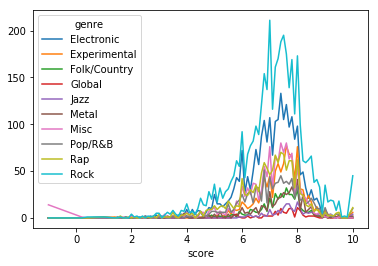

In [14]:
#order by score from high to low
ranked = pitchfork_df.sort_values(by='score', ascending=False)

#show top 50 scores
ranked.head(50)

#find all unique genres
genres = pitchfork_df.genre.unique()
print(genres)

#Create line graph of scores by genre
ranked.groupby(['score','genre']).size().unstack(fill_value=0).plot()

#Create list with the average album score by genre
avg_score = ranked.groupby(['genre'])['score'].agg(lambda x: x.unique().mean())
print(avg_score)

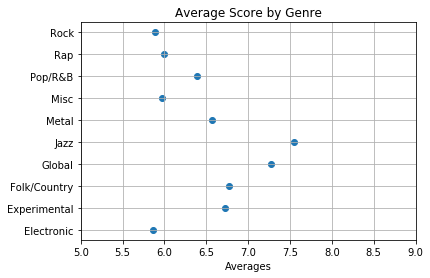

In [15]:
#Create scatter plot of average score by genre
plt.title("Average Score by Genre") #add title

plt.xlim(left=5, right=9) #set table start and end values

plt.xlabel("Averages") #add x-axis label

plt.grid(b=True, which='major', axis='both') #add grid lines

plt.scatter(avg_score[:],avg_score.index)

In [16]:
#Create dataframe of albums with a perfect score of 10
perfect = pd.DataFrame(data=None, index=None, columns=pitchfork_df.columns)
for i in range(len(pitchfork_df)):
    if pitchfork_df['score'][i] == 10.0:
        perfect = perfect.append(pitchfork_df.loc[i])
print(perfect.shape)
print(perfect)

(79, 10)
      index Unnamed: 0                                artist  \
176     176        176                        Alice Coltrane   
239     239        239                             Talk Talk   
456     456        456                         Talking Heads   
490     490        490                           Bikini Kill   
556     556        556                            De La Soul   
581     581        581                             PJ Harvey   
916     916        916                              The Band   
942     942        942                                  Hole   
1057   1057       1057                             Liz Phair   
1070   1070       1070  Captain Beefheart and His Magic Band   
1224   1224       1224                     Bruce Springsteen   
1543   1543       1543                             Metallica   
1683   1683       1683                            The Smiths   
2035   2035       2035                         Guns N' Roses   
2095   2095       2095         

The Beatles                             7
The Velvet Underground                  3
Prince                                  3
Radiohead                               2
Metallica                               2
Nirvana                                 2
David Bowie                             2
Weezer                                  2
The Rolling Stones                      2
Prince / The Revolution                 2
William Basinski                        1
Mobb Deep                               1
Liz Phair                               1
The Stone Roses                         1
Björk                                   1
R.E.M.                                  1
Pavement                                1
The Beach Boys                          1
X-Ray Spex                              1
Nas                                     1
Serge Gainsbourg                        1
Fleetwood Mac                           1
Van Morrison                            1
De La Soul                        

[Text(0, 0, 'The Beatles'),
 Text(0, 0, 'The Velvet Underground'),
 Text(0, 0, 'Prince'),
 Text(0, 0, 'Radiohead'),
 Text(0, 0, 'Metallica'),
 Text(0, 0, 'Nirvana'),
 Text(0, 0, 'David Bowie'),
 Text(0, 0, 'Weezer'),
 Text(0, 0, 'The Rolling Stones'),
 Text(0, 0, 'Prince / The Revolution')]

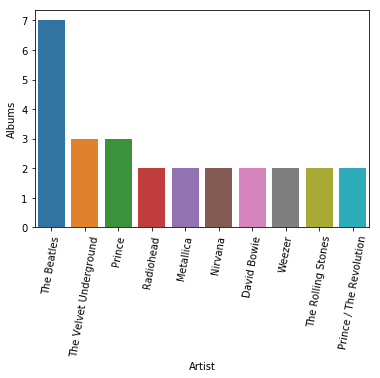

In [17]:
#Count the number of perfect scores by artist
perf_counts = perfect['artist'].value_counts()
print(perf_counts)

perf_artists = perfect.artist.unique()
#Create data frame with artists who have multiple perfect scores
perf_multi = pd.DataFrame(data=None, index=None, columns=['Artist','Albums'])
for i in range(len(perf_counts)):
    if perf_counts.values[i] > 1:
        perf_multi = perf_multi.append({'Artist' : perf_counts.index[i], 'Albums' : perf_counts.values[i]}, ignore_index=True)
print(perf_multi)

#Create bar graph of artists who have multiple perfect scores and the total perfect score per artist
ax = sns.barplot(x="Artist", y="Albums", data=perf_multi)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)

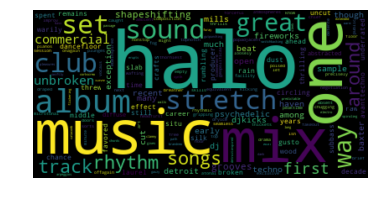

In [18]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# Start with one review:
text = pitchfork_df.review[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




# Feature Engineering

In [19]:
import nltk
from nltk.stem.porter import PorterStemmer

def tokenizeStem(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [20]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer,TfidfTransformer  
from sklearn.model_selection import GridSearchCV  
from sklearn.naive_bayes import MultinomialNB  

from sklearn.pipeline import Pipeline  
from time import time  
from sklearn.svm import LinearSVC
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/johncrider/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:

#Change the variable minisize while exploring.
# smaller numbers like .05 can be used to speed
# up processing (fewer number of documents used
# from corpus). For final processing, minisze should
# be set to 0.9999
minisize = 0.9999

X = pitchfork_df['review']
y = pitchfork_df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=minisize, random_state=42)
X_train_mini, X_test_mini, y_train_mini, y_test_mini = train_test_split(X_test, y_test,test_size=0.25)



In [27]:
#build pipeline for Support Vector Machine classifier
t0 = time()  
pipelineSVM = Pipeline([
    ('vec', CountVectorizer(tokenizer=tokenizeStem, max_df=0.5, max_features=700000, min_df=1, ngram_range=(1,3))),
    ('tfidf', TfidfTransformer()), 
    ('clf', LinearSVC())])
pipelineSVM.fit(X_train_mini, y_train_mini)
print("done in {0}s".format(time() - t0))  
print(pipelineSVM)

done in 180.21343278884888s
Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=700000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        stri...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])


# Modeling

In [28]:
#build pipeline for Naive-Bayes classifier
t0 = time()  
pipelineNB = Pipeline([
    ('vec', CountVectorizer(tokenizer=tokenizeStem, max_df=0.5, max_features=700000, min_df=1, ngram_range=(1,3))),
    ('tfidf', TfidfTransformer()), 
    ('clf', MultinomialNB(alpha=.05))])
pipelineNB.fit(X_train_mini, y_train_mini)
print("done in {0}s".format(time() - t0))  

done in 180.64982509613037s


In [29]:
#build pipeline for Neural Network classifier
t0 = time()  
pipelineNN = Pipeline([
    ('vec', CountVectorizer(tokenizer=tokenizeStem, max_df=0.5, max_features=700000, min_df=1, ngram_range=(1,3))),
    ('tfidf', TfidfTransformer()), 
    ('clf', MLPClassifier(hidden_layer_sizes=(10,9)))])
pipelineNN.fit(X_train_mini, y_train_mini)
print("done in {0}s".format(time() - t0))  

done in 400.4857180118561s


# Evaluation

In [30]:
# score for SVM
print(pipelineSVM.score(X_test_mini, y_test_mini))
# score for Naive-Bayes
print(pipelineNB.score(X_test_mini, y_test_mini))
# score for Nerual Networl
print(pipelineNN.score(X_test_mini, y_test_mini))


0.7518080210387903
0.7067718606180144
0.7481919789612097
